# Chapter 10 - Bet Sizing
## Introduction
Your ML algorithm can achieve high accuracy, but if you do not size your bets properly, your investment strategy will inevitably lose money. This notebook contains the worked exercises from the end of chapter 10 of "Advances in Financial Machine Learning" by Marcos López de Prado. The questions are restated here in this notebook, with the accompanying code solutions following directly below each question. All exercises from chapter 10 are solved in this notebook using the functionality provided by `mlfinlab`.
## Conclusion
This notebook demonstrates different bet sizing algorithms in the sample case of a *long-only* trading strategy. Simply counting and averaging the number of open bets at any given time led to a more aggressive bet sizing than the algorithm based on fit Gaussians to the distribution of open bets, as discussed in exercise 10.4. The EF3M algorithm implemented in `mlfinlab` and applied in exercise 10.4 provides a scalable and accurate way to determine the parameters of a distribution under the assumption that it is a mixture of two Gaussian distributions.
## Next Steps
While the examples in these exercises were relatively simple, it could be useful to be able to determine the parameters of a distribution under the assumption that it is a mixture of $n$ Gaussian distributions. Additionally, we would like to upgrade the optimization algorithm for EF3M to reduce the amount of time needed to get high accuracy.

----
----
## Exercises
Below are the worked solutions to the exercises. All code can be run as is in this notebook.

In [19]:
# imports
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm, moment
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from IPython.display import display

from mlfinlab.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve,
                                 confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed,
                                 M2N, centered_moment, raw_moment, most_likely_parameters)
from mlfinlab.bet_sizing.ch10_snippets import avg_active_signals

----
#### EXERCISE 10.1
Using the formulation in Section 10.3, plot the bet size ($m$) as a function of the maximum predicted probability ($\tilde{p}$) when $||X|| = 2, 3, ..., 10$.

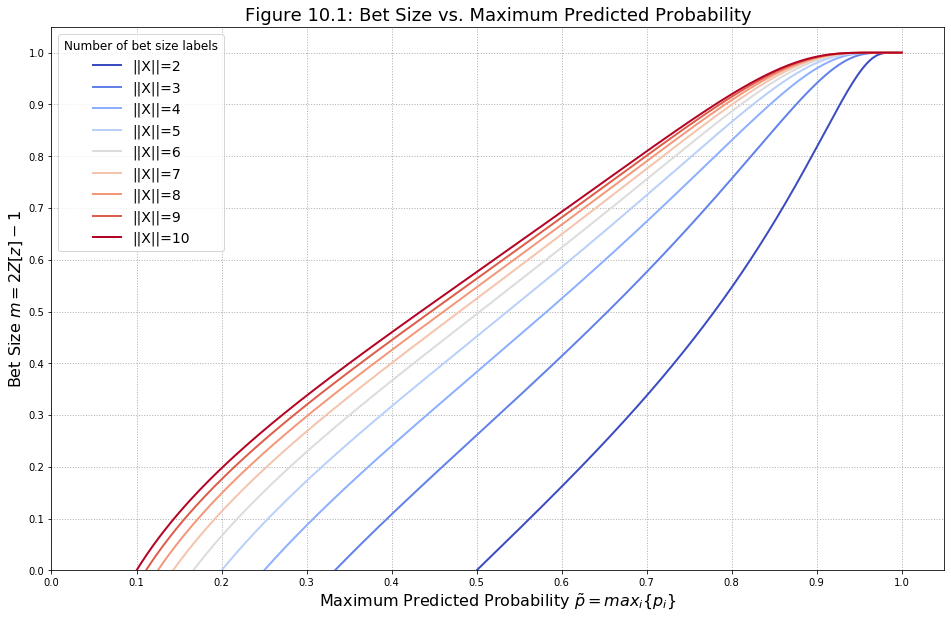

In [12]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
sample_size = 10_000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

# === Setup the t1 Series, also used for exercise 10.2 ===
# Create the array of dates.
start_date = dt.datetime(2000, 1, 1)  # starting at 01-JAN-2000
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(sample_size)])
# Create the array of shifted dates to be the end date of the bet.
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days=d) for d in shift_list])
# Combine into a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data=dates_shifted, index=dates)

# Start plotting loop.
fig_10_1, ax_10_1 = plt.subplots(figsize=(16, 10))

for num_classes in num_classes_list:
    # Create the array of random probabilities.
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, sample_size, endpoint=False)  # range of maximum predicted probabilities to plot
    # Combine probabilities with 
    events_n_classes = pd.DataFrame({'t1': t1, 'prob': P})
    events_n_classes['bet_size_prob'] = bet_size_probability(events=events_n_classes, prob=events_n_classes['prob'], num_classes=num_classes)
    ax_10_1.plot(events_n_classes['prob'], events_n_classes['bet_size_prob'], label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=16)
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=16)
ax_10_1.set_title("Figure 10.1: Bet Size vs. Maximum Predicted Probability", fontsize=18)
ax_10_1.set_xticks([0.1*i for i in range(11)])
ax_10_1.set_yticks([0.1*i for i in range(11)])
ax_10_1.legend(loc="upper left", fontsize=14, title="Number of bet size labels", title_fontsize=12)
ax_10_1.set_ylim((0,1.05))
ax_10_1.set_xlim((0, 1.05))
ax_10_1.grid(linewidth=1, linestyle=':')

plt.show()

**Figure 10.1** shows the bet size vs. the maximum predicted probability given the number of discrete bet size labels. The left-side of each line represents the case in which the maximum probability across the size labels is $\frac{1}{||X||}$ and all probabilities are equal, leading to a bet size of zero. Note the bet size reaches the limiting value $1.0$ faster at greater values of $||X||$, since the greater number of alternative bets spreads the remaining probability much thinner, leading to a greater confidence in that with the maximum predicted probability.

----
#### EXERCISE 10.2
Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

__(a)__ Compute bet sizes _m_ for $||X||=2$.

__(b)__ Assign 10,000 consecutive calendar days to the bet sizes.

__(c)__ Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

__(d)__ Form a `pandas.Series` indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a `t1` object similar to the ones we used in Chapter 3.

__(e)__ Compute the resulting average active bets, following Section 10.4.
 

In [23]:
# Draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10_000
P_t = np.random.uniform(.5, 1., sample_size)  # array of random from uniform dist.
# Create events DataFrame from P_t and t1 (previous exercise).
events_2_classes = pd.DataFrame({'t1': t1, 'prob': P_t})

# 10.2(a) Compute bet sizes for ||X||=2
events_2_classes['bet_size_prob'] = bet_size_probability(events=events_2_classes, prob=events_2_classes['prob'], num_classes=2)

# 10.2(b) Assign 10,000 consecutive calendar days.
# See previous code cell.

# 10.2(c) Draw 10,000 random numbers from a uniform distribution.
# See previous code cell.

# 10.2(d) Create a pandas.Series object.
# See previous cell.

# Since this is a long-only strategy, all bet sides are '1'.
events_2_classes['side'] = 1

# 10.2(e) Compute the average active bets (sizes).
# Calculate the concurrent long and short bets.
avg_active_bet_sizes = avg_active_signals(events_2_classes.rename(columns={'bet_size_prob': 'signal'}), num_threads=cpu_count())
events_2_classes['avg_active_bet_size'] = avg_active_bet_sizes

print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(events_2_classes.head(10))
print("Summary statistics on the bet size columns:")
display(events_2_classes[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())


2019-09-11 21:16:28.495708 100.0% mp_avg_active_signals done after 0.17 minutes. Remaining 0.0 minutes.


The first 10 rows of the resulting DataFrame from Exercise 10.2:


,t1,prob,bet_size_prob,side,avg_active_bet_size
2000-01-01,2000-01-12 02:22:00.372377,0.774407,0.488510,1,0.488510
2000-01-02,2000-01-26 14:30:45.591877,0.857595,0.693816,1,0.591163
2000-01-03,2000-01-16 10:43:17.855214,0.801382,0.550002,1,0.577443
2000-01-04,2000-01-21 04:19:41.819598,0.772442,0.484193,1,0.554130
2000-01-05,2000-01-28 23:35:31.215456,0.711827,0.360002,1,0.515304
2000-01-06,2000-01-07 16:36:59.536166,0.822947,0.602473,1,0.529832
2000-01-07,2000-01-13 10:59:40.405697,0.718794,0.373496,1,0.507499
2000-01-08,2000-01-13 04:37:03.266890,0.945887,0.951258,1,0.557325
2000-01-09,2000-01-23 04:57:52.633398,0.981831,0.999691,1,0.612621
2000-01-10,2000-01-22 10:37:59.217780,0.691721,0.321986,1,0.580328


Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,10000.000000,10000.000000,10000.000000
mean,0.748229,0.473318,0.473109
std,0.144803,0.312169,0.083359
min,0.500036,0.000058,0.206510
25%,0.622655,0.199764,0.416575
50%,0.746751,0.429563,0.472927
75%,0.874146,0.740689,0.528092
max,0.999989,1.000000,0.755975


----
#### EXERCISE 10.3
Using the `t1` object from exercise 2.d:

__(a)__ Determine the maximum number of concurrent long bets, $\bar{c_l}$.

__(b)__ Determine the maximum number of concurrent short bets, $\bar{c_s}$.

__(c)__ Derive the bet size as $m_t = c_{t,l}\frac{1}{\bar{c_l}} - c_{t,s}\frac{1}{\bar{c_s}}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

In [4]:
# 10.3(a) max number of concurrent long bets
df_events2 = df_events.copy()
active_long = pd.Series()
active_short = pd.Series()

for idx in df_events2.index:
    # long bets are defined as having a prediction probability greater than or equal to 0.5
    df_long_active_idx = set(df_events2[(df_events2.index<=idx) & (df_events2.t1>idx) & (df_events2.p>=0.5)].index)
    active_long[idx] = len(df_long_active_idx)
    # short bets are defined as having a prediction probability less than 0.5
    df_short_active_idx = set(df_events2[(df_events2.index<=idx) & (df_events2.t1>idx) & (df_events2.p<0.5)].index)
    active_short[idx] = len(df_short_active_idx)


print(f"  10.3(a) Maximum number of concurrent long bets: {active_long.max()}")

# 10.3(b) max number of concurrent short bets
# p[x=1]: U[0.5, 1], thus all bets are long, and the 
# number of concurrent short bets is always zero in this exercise.
print(f"  10.3(b) Maximum number of concurrent short bets: {active_short.max()}")


# 10.3(c) bet size as difference between fractions of concurrent long and short bets
# Handle possible division by zero.
avg_active_long = active_long/active_long.max() if active_long.max() > 0 else active_long
avg_active_short = active_short/active_short.max() if active_short.max() > 0 else active_short
bet_sizes_2 = avg_active_long - avg_active_short

df_events2 = df_events2.assign(active_long=active_long,
                               active_short=active_short,
                               bet_sizes2=bet_sizes_2)
display(df_events2.head(10))

  10.3(a) Maximum number of concurrent long bets: 20
  10.3(b) Maximum number of concurrent short bets: 0


,t1,p,bet_size,num_active_bets,avg_active_bets,active_long,active_short,bet_sizes2
2000-01-01,2000-01-19 23:00:08.486002,0.774407,0.488510,1,0.488510,1,0,0.05
2000-01-02,2000-01-07 07:47:48.333891,0.857595,0.693816,2,0.591163,2,0,0.10
2000-01-03,2000-01-13 08:04:38.392503,0.801382,0.550002,3,0.577443,3,0,0.15
2000-01-04,2000-01-05 21:39:27.736493,0.772442,0.484193,4,0.554130,4,0,0.20
2000-01-05,2000-01-06 06:47:23.055965,0.711827,0.360002,5,0.515304,5,0,0.25
2000-01-06,2000-01-30 21:51:01.058622,0.822947,0.602473,5,0.538960,5,0,0.25
2000-01-07,2000-01-19 17:12:04.590144,0.718794,0.373496,5,0.541659,5,0,0.25
2000-01-08,2000-01-17 22:17:10.550572,0.945887,0.951258,5,0.593148,5,0,0.25
2000-01-09,2000-01-14 16:59:42.455288,0.981831,0.999691,6,0.660905,6,0,0.30
2000-01-10,2000-01-30 08:56:33.839416,0.691721,0.321986,7,0.612488,7,0,0.35


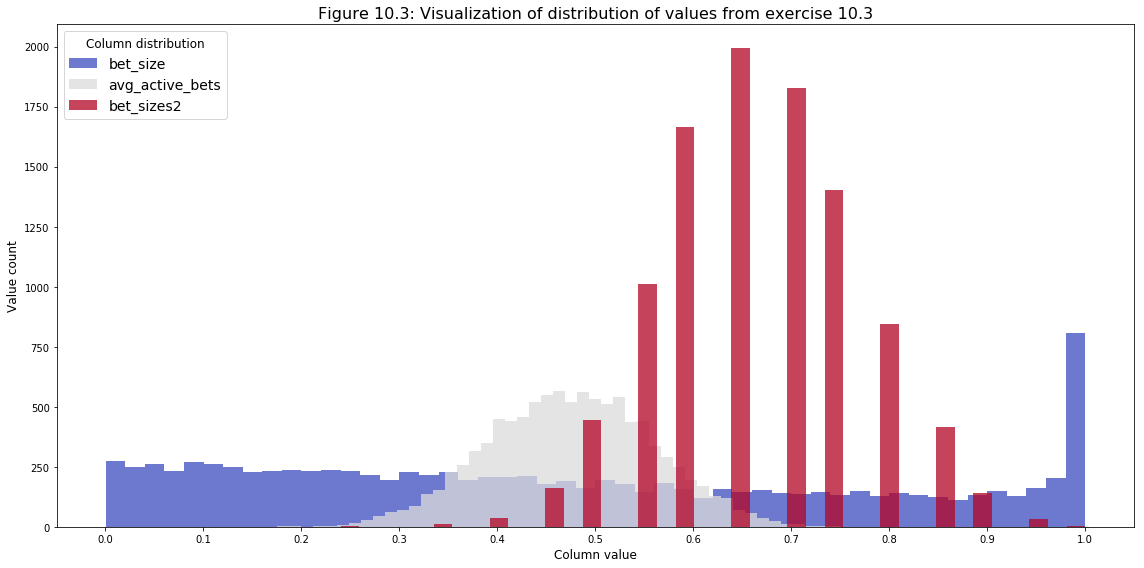

In [5]:
# plot the frequency of different bet sizes
fig_10_3, ax_10_3 = plt.subplots(figsize=(16, 8))
colors = iter(cm.coolwarm(np.linspace(0,1,3)))
n_bins = 50
for i, col in enumerate(['bet_size', 'avg_active_bets', 'bet_sizes2']):
    ax_10_3.hist(df_events2[col], bins=n_bins, alpha=0.75, color=colors.__next__(), label=col)
ax_10_3.set_xticks([i/10 for i in range(11)])
ax_10_3.set_xlabel("Column value", fontsize=12)
ax_10_3.set_ylabel("Value count", fontsize=12)
ax_10_3.set_title("Figure 10.3: Visualization of distribution of values from exercise 10.3", fontsize=16)
ax_10_3.legend(loc="upper left", fontsize=14, title="Column distribution", title_fontsize=12)
fig_10_3.tight_layout()
plt.show()

**Figure 10.3** visualizes the distributions of bet sizes found in the DataFrame as of exercise 10.3. `bet_size` is the bet size calculated from predicted probilities, $m=2Z[z]-1$, as in section 10.3, and runs between $[0, 1]$ as seen in **Figure 10.1**. `avg_active_bets` is the average of the values of active bets in `bet_size` at any given time. Values for `bet_sizes2` are calculated as described in section 10.2, and take on 20 discrete values since the maximum number of concurrent bets is 20 and the minimum is 1 (there is always at least one active bet). 

----
#### EXERCISE 10.4
Using the `t1` object from exercise 2.d:

__(a)__ Compute the series $c_t = c_{t,l} - c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

__(b)__ Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in López de Prado and Foreman (2014).

__(c)__ Derive the bet size as $$m_t = \begin{cases} \frac{F[c_t]-F[0]}{1-F[0]}, & \text{if } c_t\geq 0\\\
                                                     \frac{F[c_t]-F[0]}{F[0]}, & \text{if } c_t\le 0
\end{cases}$$
where $F[x]$ is the CDF of the fitted mixture of two Gaussians for a value of $x$.

__(d)__ Explain how this series ${m_t}$ differ from the bet size computed in exercise 3.


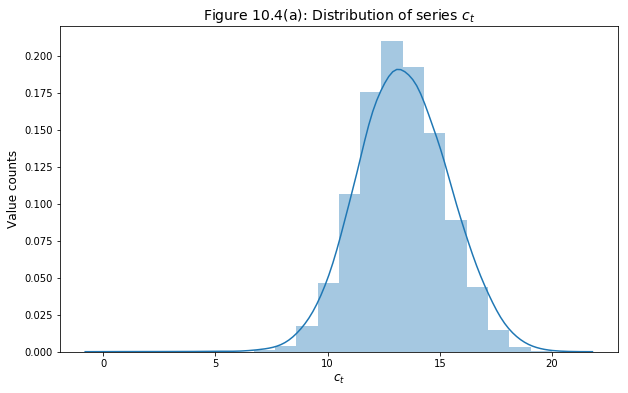

In [6]:
# 10.4(a) compute the series c_t = c_{t,l} (all bets are long)
# ======================================================
df_events2['c_t'] = df_events2.active_long - 0  # number of short bets is always zero
fig_10_4, ax_10_4 = plt.subplots(figsize=(10,6))
ax_10_4a = sns.distplot(df_events2['c_t'], bins=20, kde=True, kde_kws={"bw":0.6}, norm_hist=False, ax=ax_10_4)
ax_10_4a.set_xlabel('$c_t$', fontsize=12)
ax_10_4.set_ylabel("Value counts", fontsize=12)
ax_10_4a.set_title("Figure 10.4(a): Distribution of series $c_t$", fontsize=14)
plt.show()

**Figure 10.4(a)** shows the distribution of the number of concurrent long bets at any given time $t$. Note the slightly longer tail to the left due to the maximum number of bets being limiting in the start of the sequence.

In [7]:
# 10.4(b) fit a mixture of 2 Gaussians
# compute the first 5 centered moments
# ======================================================
print(f"Mean (first raw moment): {df_events2.c_t.mean()}")
print("First 5 centered moments")
mmnts = [moment(df_events2.c_t.to_numpy(), moment=i) for i in range(1, 6)]
for i, mnt in enumerate(mmnts):
    print(f"E[r^{i+1}] = {mnt}")

Mean (first raw moment): 13.375
First 5 centered moments
E[r^1] = 0.0
E[r^2] = 3.948975
E[r^3] = -0.33733125
E[r^4] = 51.253873828125
E[r^5] = -78.8945244140625


The EF3M algorithm that we plan to implment uses the first 5 raw moments, so we must convert the centered moments (just previously calculated) to raw moments using the `rawMoment` function from `ef3m.py`.

In [8]:
# Calculate raw moments from centered moments
# ======================================================
raw_mmnts = rawMoment(central_moments=mmnts, dist_mean=df_events2.c_t.mean())
for i, mnt in enumerate(raw_mmnts):
    print(f"E_Raw[r^{i+1}]={mnt}")

E_Raw[r^1]=13.375
E_Raw[r^2]=182.8396
E_Raw[r^3]=2550.7774
E_Raw[r^4]=36273.67
E_Raw[r^5]=525255.703


Now that we have the first 5 raw moments, we can apply the EF3M algorithm. We use variant 2 since we have the 5th moment, and it converges faster in practice. While the first 3 moments are fit exactly, there is not a unqiue solution to this, so we have to make multple runs to find the most likely value. We visualize the results of the fitted parameters in histograms, and use a kernel density estimate to identify the most likely value for each parameter.

[########################################] | 100% Completed |  2min 16.9s
[########################################] | 100% Completed | 27min 47.5s
=== Values chosen based on the mode of the distribution of results from EF3M (50 runs) ===
Most probable estimate for parameter 'mu1': 12.574
Most probable estimate for parameter 'mu2': 13.39
Most probable estimate for parameter 'sigma1': 3.306
Most probable estimate for parameter 'sigma2': 1.95
Most probable estimate for parameter 'p1': 0.017


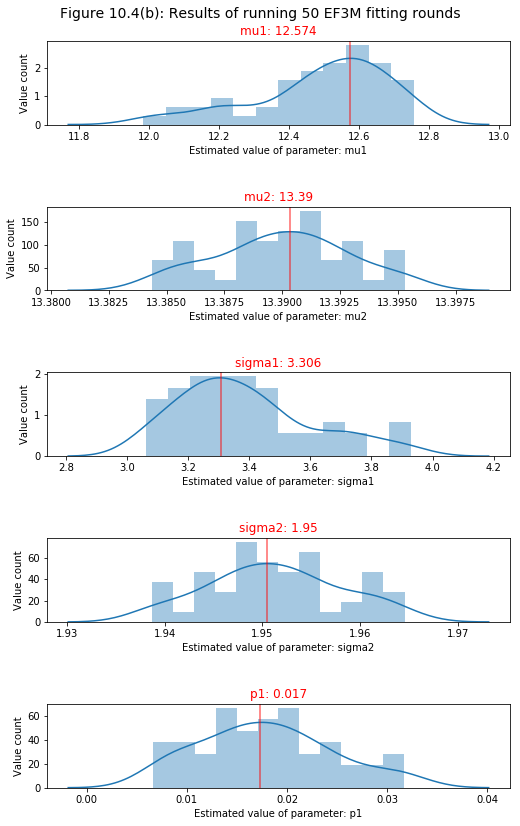

In [9]:
# On an Intel i7-7700K with 32GB RAM, execution times are as follows:
# 10 runs will take approximately 6 minutes
# 100 runs will take approximately 1 hour
# 1000 runs will take approximately 9 hours
# ======================================================
n_runs = 50
m2n = M2N(raw_mmnts)
df_10_4 = m2n.mpFit(raw_mmnts, epsilon=10**-5, factor=5, n_runs=n_runs, variant=2, maxIter=10_000_000)


# Visualize results and determine the most likely values from a KDE plot
# ======================================================
fig_10_4b, ax_10_4b = plt.subplots(nrows=5, ncols=1, figsize=(8,12))
cols = ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1']
bins = int(n_runs / 4)  # to minimize number of bins without results, choose at own discretion
fit_parameters = []

print(f"=== Values chosen based on the mode of the distribution of results from EF3M ({n_runs} runs) ===")

for col_i, ax in enumerate(ax_10_4b.flatten()):
    col = cols[col_i]
    df = df_10_4.copy()
    df[col+'_bin'] = pd.cut(df[col], bins=bins)
    df = df.groupby([col+'_bin']).count()
    ax = sns.distplot(df_10_4[col], bins=bins, kde=True, ax=ax)
    dd = ax.get_lines()[0].get_data()
    most_probable_val = dd[0][np.argmax(dd[1])]
    fit_parameters.append(most_probable_val)
    ax.set_ylabel("Value count")
    ax.set_xlabel(f"Estimated value of parameter: {col}")
    ax.axvline(most_probable_val, color='red', alpha=0.6)
    ax.set_title(f"{col}: {round(most_probable_val,3)}", color='red')
    print(f"Most probable estimate for parameter '{col}':", round(dd[0][np.argmax(dd[1])], 3))
fig_10_4b.suptitle(f"Figure 10.4(b): Results of running {n_runs} EF3M fitting rounds", fontsize=14)
fig_10_4b.tight_layout(pad=3.5)
plt.show()

**Figure 10.4(b)** shows the distribution of the parameter estimates from the fitting rounds. The red vertical line indicates the most likely value for each parameter according to the KDE, with the estimated value stated above the subplot in red.

The CDF of a [mixture of $n$ distributions](https://en.wikipedia.org/wiki/Mixture_distribution), $F_{mixture}(x)$, can be represented as the weighted sum of the individual distributions:
$$ F_{mixture}(x) = \sum_{i=1}^{n}{w_i F_{i, norm}(x)}$$
Where $w_i$ are the weights corresponding to each of the individual cumulative distribution functions of a normal distribution, $F_{i,norm}(x)$.

Thus, for the mixture of $n=2$ distributions in this question, the CDF of the mixture, $F(x)$, is:
$$ F(x) = p_1 F_{norm}(x, \mu_1, \sigma_1) + (1-p_1) F_{norm}(x, \mu_2, \sigma_2) $$
Where $F_{norm}(x, \mu_i, \sigma_i)$ is the cumulative distribution evaluated at $x$ of a Normal distribution with parameters $\mu_i$ and $\sigma_i$, and $p_1$ is the probability of a given random sample being drawn from the first distribution.

,c_t,bet_sizes2,bet_sizes3
count,10000.000000,10000.000000,10000.000000
mean,13.375000,0.668750,0.498150
std,1.987302,0.099365,0.290257
min,1.000000,0.050000,0.000003
25%,12.000000,0.600000,0.241321
50%,13.000000,0.650000,0.422952
75%,15.000000,0.750000,0.794925
max,20.000000,1.000000,0.999441


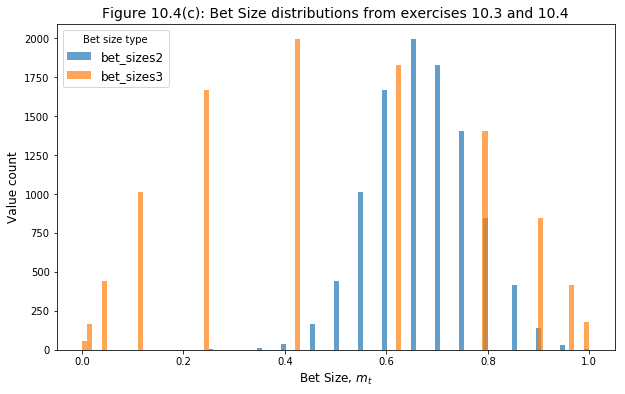

In [10]:
# 10.4(c) Calculating the bet size using the mixture of 2 Gaussians
# ======================================================

def cdf_mixture(x, parameters):
    # the CDF of a mixture of 2 normal distributions, evaluated at x
    # :param x: (float) x-value
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) CDF of the mixture
    # ===================================
    mu1, mu2, sigma1, sigma2, p1 = parameters  # for clarity
    return p1*norm.cdf(x, mu1, sigma1) + (1-p1)*norm.cdf(x, mu2, sigma2)

def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / ( 1 - cdf_mixture(0, parameters) )
    else:
        ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / cdf_mixture(0, parameters)

df_events2['bet_sizes3'] = df_events2.c_t.apply(lambda c: bet_size_mixed(c, fit_parameters))
fig_10_4c, ax_10_4c = plt.subplots(figsize=(10,6))
for c in ['bet_sizes2', 'bet_sizes3']:
    ax_10_4c.hist(df_events2[c].to_numpy(), bins=100, label=c, alpha=0.7)
ax_10_4c.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax_10_4c.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax_10_4c.set_ylabel("Value count", fontsize=12)
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4", fontsize=14)
display(df_events2[['c_t', 'bet_sizes2', 'bet_sizes3']].describe())

**Figure 10.4(c)** shows the distribution of bet sizes as calculated in exercises 10.3 and 10.4. `bet_sizes2` is the number of active bets divided by the maximum number of active bets, while `bet_sizes3` is the bet sizes calculated using the fit mixture of 2 Gaussian distributions. Note that both are 20 discrete values due to the underlying data as previously discussed.

**10.4(d) Discussion**

The bet size distribution calculated in exercise 3, `bet_sizes2`, and exercise 4, `bet_sizes3`, are both made up of discrete values. Since the series $\{c_t\}$ is made up of integers between 1 and 20, the bet size from exercise 3, $m_t=c_{t,l}\frac{1}{\tilde{c_l}}$, is also a set of discrete values bounded by $[\frac{1}{\tilde{c_l}}, 1]$ (since there is always at least 1 active bet for any given $t$). However, $98\%$ of all bet sizes fall between $[0.45, 0.9]$, with a mean at $0.67$.

In exercise 4 the bet size is calculated using $c_t$ as an input, which results in the bet sizes being a series composed of 20 unique values. Here the bet size values are bounded by $(0, 1)$ but are spread out more evenly across the range than in exercise 3; here $98\%$ of the bet sizes fall between $[0.014, 0.998]$, with a lower mean of $0.50$.

Even though we are examining a *long-only* betting strategy, the bet sizes calculated in exercise 4 typically get much closer to zero (i.e. not placing the bet at all), whereas in exercise 3 $99\%$ of all bet sizes are at least $0.45$.

In [11]:
print("Quantiles of the bet size values as calculated in the previous exercises:")
display(df_events2.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]))

Quantiles of the bet size values as calculated in the previous exercises:


,p,bet_size,num_active_bets,avg_active_bets,active_long,active_short,bet_sizes2,c_t,bet_sizes3
0.001,0.500363,0.000580,7.0,0.229428,7.0,0.0,0.35,7.0,0.001311
0.010,0.504100,0.006542,9.0,0.284154,9.0,0.0,0.45,9.0,0.014406
0.050,0.523658,0.037781,10.0,0.338003,10.0,0.0,0.50,10.0,0.044152
0.250,0.622655,0.199764,12.0,0.415641,12.0,0.0,0.60,12.0,0.241321
0.500,0.746751,0.429563,13.0,0.474385,13.0,0.0,0.65,13.0,0.422952
0.750,0.874146,0.740689,15.0,0.532511,15.0,0.0,0.75,15.0,0.794925
0.950,0.974606,0.997446,17.0,0.613095,17.0,0.0,0.85,17.0,0.966883
0.990,0.994703,1.000000,18.0,0.663246,18.0,0.0,0.90,18.0,0.990229
0.999,0.999551,1.000000,19.0,0.714011,19.0,0.0,0.95,19.0,0.997572


----
#### EXERCISE 10.5
Repeat exercise 1, where you discretize $m$ with a `stepSize=.01`, `setpSize=.05`, and `stepSize=.1`.

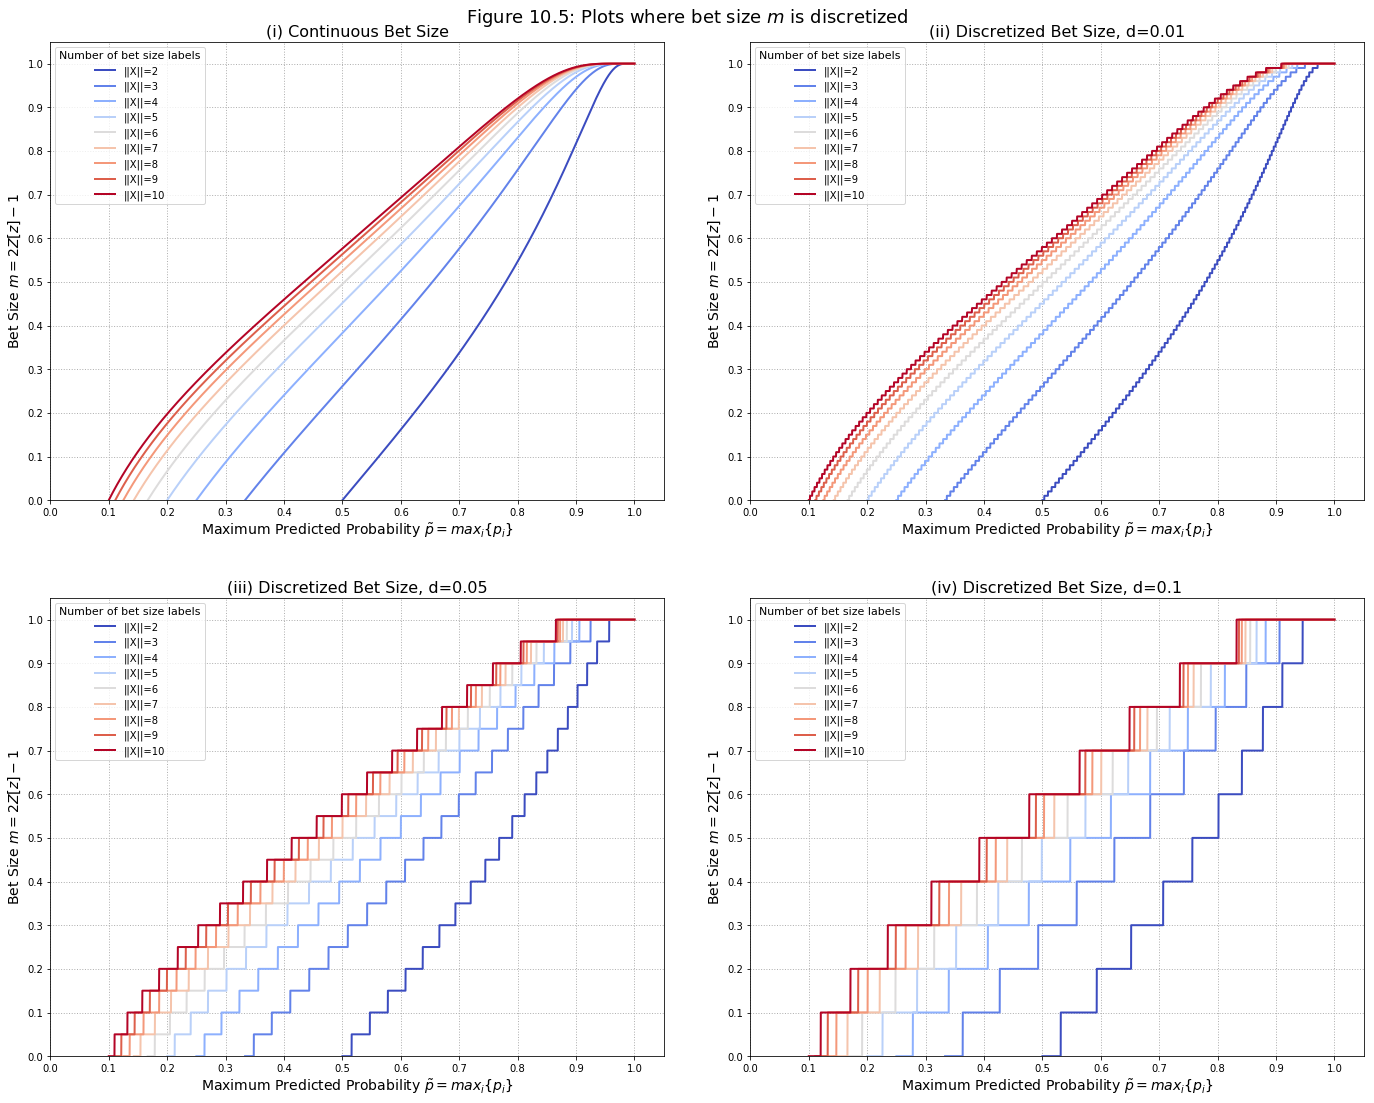

In [12]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot


fig_10_5, ax_10_5 = plt.subplots(2, 2, figsize=(20, 16))
ax_10_5 = fig_10_5.get_axes()
d_list = [None, 0.01, 0.05, 0.1]
d = d_list[2]
sub_fig_num = ['i', 'ii', 'iii', 'iv']

for i, axi in enumerate(ax_10_5):
    colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for num_classes in num_classes_list:
        d = d_list[i]
        min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
        z = (P - min_prob) / (P*(1-P))**0.5
        m = 2 * norm.cdf(z) - 1
        if not isinstance(d, type(None)):
            m = (m/d).round()*d
        axi.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

    axi.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=14)
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=14)
    axi.set_xticks([0.1*i for i in range(11)])
    axi.set_yticks([0.1*i for i in range(11)])
    axi.legend(loc="upper left", fontsize=10, title="Number of bet size labels", title_fontsize=11)
    axi.set_ylim((0,1.05))
    axi.set_xlim((0, 1.05))
    if not isinstance(d, type(None)):
        axi.set_title(f"({sub_fig_num[i]}) Discretized Bet Size, d={d}", fontsize=16)
    else:
        axi.set_title(f"({sub_fig_num[i]}) Continuous Bet Size", fontsize=16)
    axi.grid(linewidth=1, linestyle=':')

fig_10_5.suptitle("Figure 10.5: Plots where bet size $m$ is discretized", fontsize=18)
fig_10_5.tight_layout(pad=4)
plt.show()

**Figure 10.5** shows the bet size calculated from predicted probabilities using (i) a continuous bet size, as well as bet sizes discretized by step sizes of (ii) $d=0.01$, (iii) $d=0.05$, and (iv) $d=0.1$. 

----
#### EXERCISE 10.6
Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$

$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$

The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[\frac{\tilde{m}}{sgn(x)}]}{log[|x|]}$$

Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

----
#### EXERCISE 10.7
Modify Snippet 10.4 so that in implements the equations you derived in exercise 6.

In [13]:
# Snippet 10.4, modified to use a power function for the Bet Size
# ===============================================================
# pos    : current position
# tPos   : target position
# w      : coefficient for regulating width of the bet size function (sigmoid, power)
# f      : forecast price
# mP     : market price
# x      : divergence, f - mP
# maxPos : maximum absolute position size
# ===============================================================

def betSize_power(w, x):
    # returns the bet size given the price divergence
    sgn = np.sign(x)
    return sgn * abs(x)**w

def getTPos_power(w, f, mP, maxPos):
    # returns the target position size associated with the given forecast price
    return int( betSize_power(w, f-mP)*maxPos )

def invPrice_power(f, w, m):
    # inverse function of bet size with respect to the market price
    sgn = np.sign(m)
    return f - sgn*abs(m)**(1/w)

def limitPrice_power(tPos, pos, f, w, maxPos):
    # returns the limit price given forecast price
    sgn = np.sign(tPos-pos)
    lP = 0
    for j in range(abs(pos+sgn), abs(tPos+1)):
        lP += invPrice_power(f, w, j/float(maxPos))
    lP = lP / (tPos-pos)
    return lP

def getW_power(x, m):
    # inverse function of the bet size with respect to the 'w' coefficient
    return np.log(m/np.sign(x)) / np.log(abs(x))


In [14]:
# a short script to check calculations forwards and backwards
# ===============================================================
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
w = getW_power(wParams['divergence'], wParams['m'])  # calibrate w

# checking forward and backward calculations
m_test = betSize_power(w, f-mP)
mP_test = invPrice_power(f, w, m_test)
w_test = getW_power(f-mP, m_test)
print(f"Market price: {mP}; Result of inverse price: {mP_test}; Diff: {abs(mP-mP_test)}")
print(f"w: {w}; Result of inverse w: {w_test}; Diff: {abs(w-w_test)}")


Market price: 100; Result of inverse price: 100.00000000000003; Diff: 2.842170943040401e-14
w: -0.02227639471115225; Result of inverse w: -0.022276394711152232; Diff: 1.734723475976807e-17


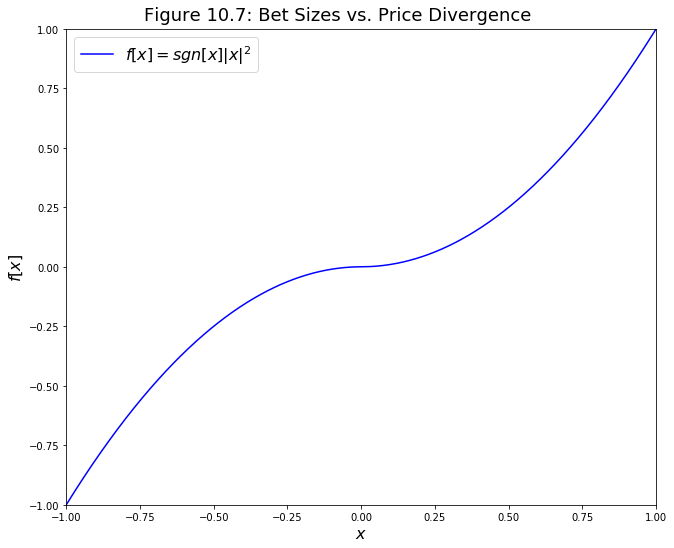

In [15]:
# setup data for replicating Figure 10.3
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
n_points = 1000
X = np.linspace(-1.0, 1.0, n_points)

w = 2
bet_sizes_power = np.array([betSize_power(w, xi) for xi in X])

# plotting
fig_10_7, ax_10_7 = plt.subplots(figsize=(10,8))
ax_10_7.plot(X, bet_sizes_power, label='$f[x]=sgn[x]|x|^2$', color='blue', linestyle='-')
ax_10_7.set_xlabel("$x$", fontsize=16)
ax_10_7.set_ylabel("$f[x]$", fontsize=16)
ax_10_7.set_xlim((-1, 1))
ax_10_7.set_ylim((-1, 1))
fig_10_7.suptitle("Figure 10.7: Bet Sizes vs. Price Divergence", fontsize=18)
plt.legend(loc='upper left', fontsize=16)
fig_10_7.tight_layout(pad=3)
plt.show()

**Figure 10.7** shows a plot of bet size vs. price divergence using the same parameters as Figure 10.3 on page 148 of "Advances in Financial Machine Learning".